As described in the other data augmentation notebook file, the data augmentation algorithm serves two purposes: (1) simplify the form of an analytically intractable or messy posterior distribution, allowing us to sample it efficiently, or (2) better approximate the posterior distribution in cases where we have "missing" or "incomplete" data. Here, I demonstrate the former using an example adapted from Tanner, 1996. 

As explained before, the data augmentation algorithm "imputes" latent variables from the current conditional predictive distribution (based on the current approximation to the posterior distribution) that "complete" the observed data. Then, using the augmented data, we update the approximation to the posterior distribution. The algorithm iterates until it converges to the best approximation to the posterior distribution. 

We consider the genetic linkage model. Suppose 197 animals are distributed into four categories as follows: $$Y = (y_{1}, y_{2}, y_{3}, y_{4}) = (125, 18, 20, 34)$$ with cell probabilities $$(1/2 + \frac{\theta}{4}, \frac{1 - \theta}{4}, \frac{1 - \theta}{4}, \frac{\theta}{4}).$$ Under a flat prior, the posterior distribution is $$p(\theta | y) \propto (2 + \theta)^{y_{1}}(1 - \theta)^{y_{2} + y_{3}}\theta^{y_4}.$$ However, we will see that we can simplify the form of the posterior if we split the first cell into two cells. Specifically, we describe the latent variables x by the relationship $$y_{1} = x_{1} + x{2}$$  $$y_{2} = x_{3}$$ $$y_{3} = x_{4}$$ $$y_{4} = x_{5}$$ where x has cell probabilities $$(\frac{1}{2}, \frac{\theta}{4}, \frac{1 - \theta}{4}, \frac{1 - \theta}{4}, \frac{\theta}{4}).$$ Under a flat prior, the posterior distribution is given by $$p(\theta | x) \propto \theta^{x_{2} + x_{5}}(1 - \theta)^{x_{3} + x_{4}}.$$ Note that this augmented posterior depends on $x_{2}$, but we have not actually observed this random variable yet. 

Since the augmented posterior depends on $x_{2}$, we must choose a way to assign counts in $y_{1}$ to counts in $x_{2}$. We see that the conditional predictive distribution for $x_{2}$ is given by $$ x_{2} ~ Binom(n = y_{1}, p = \frac{\theta}{\theta + 2}).$$ To be clear, this is the probability that a count from $y_{1}$ falls in the $x_{2}$ cell when using separating the first observed cell into the first two augmented cells. We just divide the probability of being in $x_{2}$ by the probability of being in $x_{1}$ or $x_{2}$. 

Thus, at each iteration of the algorithm, we generate $x_{2}$ from the current conditional predictive distribution using $\theta^{*}$. Then, we update the posterior distribution, and repeat the process. Once the algorithm has converged, we sample the current posterior distribution. 

Iteration:  0
Arrived at final approximation to the posterior distribution
Adding labels


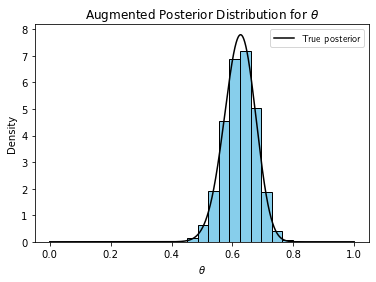

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
from scipy.stats import norm

y1, y2, y3, y4 = [125, 18, 20, 34]

numIterations = 100
numImputations = 5000
posteriorApproximations = np.zeros([numIterations, numImputations])
randomIndices = random.choices(range(numImputations), k = numIterations)
currentTheta = np.random.uniform(0, 1, numImputations)

for iiIteration in range(numIterations):

    # Display every n'th iteration

    if iiIteration % 100 == 0:
        
        print('Iteration: ', iiIteration)

    # Generate m imputations / latent variables from the current posterior distribution (represented by a sample of thetas not just one theta)

    currentImputations = np.zeros([numImputations])

    for jjImputation in range(numImputations):

        thetaStar = currentTheta[jjImputation]
        currentImputations[jjImputation] = np.random.binomial(y1, thetaStar / (thetaStar + 2), 1)

    # Now sample theta star from Beta(v1, v2) where v1 = x2 + y4 + 1 and v2 = y2 + y3

    for jjImputation in range(numImputations):

        currentLatentVariable = currentImputations[random.randint(0, numImputations - 1)] # drawn from the conditional predictive distribution given the current approximation to the posterior
        currentTheta[jjImputation] = np.random.beta(currentLatentVariable + y4 + 1, y2 + y3 + 1, 1) # sampling the current approximation to the posterior
        # (which of course depends on the latent variables that in turn depend on the previous approximation to the posterior)
        posteriorApproximations[iiIteration, jjImputation] = currentTheta[jjImputation]

    if iiIteration == (numIterations - 1):

        print('Arrived at final approximation to the posterior distribution')


## Plot the true posterior distribution as well 
        
theta = np.linspace(0, 1, 10000)
trueDensity = ((2 + theta) ** y1) * ((1 - theta) ** (y2 + y3)) * (theta ** y4)

# Normalize the true density 

deltaTheta = theta[1] - theta[0]
normalizingConstant = np.sum(deltaTheta * trueDensity)
trueDensity = trueDensity / normalizingConstant

posteriorSample = currentTheta
plt.hist(posteriorSample, density = True, color = 'skyblue', edgecolor = 'black')
plt.plot(theta, trueDensity, color = 'black', label = 'True posterior')
print('Adding labels')
plt.rc('text', usetex = True)
plt.xlabel('$\\theta$')
plt.ylabel('Density')
plt.title('Augmented Posterior Distribution for $\\theta$')
plt.legend()
plt.show()

quantiles = np.array([.025, .50, .975])
convergenceQuantiles = np.quantile(posteriorApproximations, quantiles, axis = 1) 


We can see that the sample from the augmented posterior agrees well with the true analytical density. We have made use of the fact that we can easily sample a very good approximation to the posterior by augmenting the observed data with latent variables. We can also see that the posterior distribution converges in just a handful of iterations. 

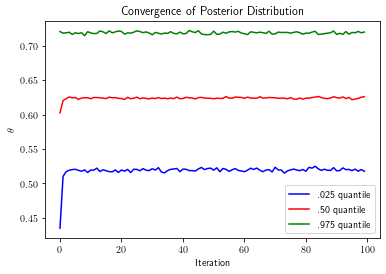

In [2]:
colors = np.array(['blue', 'red', 'green'])
labels = np.array(['.025 quantile', '.50 quantile', '.975 quantile'])

for iiQuantile in range(len(quantiles)):

    plt.plot(convergenceQuantiles[iiQuantile, :], color = colors[iiQuantile], label = labels[iiQuantile])

plt.xlabel('Iteration')
plt.rc('text', usetex = True)
plt.ylabel('$\\theta$')
plt.title('Convergence of Posterior Distribution')
plt.legend()
plt.show()